In [6]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import minimize_scalar

project_root = Path.cwd().parent
print(f"Project root: {project_root}")

Project root: /Users/david/Code/msc


In [7]:
run_name = input("Enter the run name: ").strip()
run_folder = project_root / "runs" / run_name
distance_process_path = run_folder / "distance_process.csv"

if not distance_process_path.exists():
    raise FileNotFoundError(f"No distance_process.csv found at {distance_process_path}")

df = pd.read_csv(distance_process_path)
print(df.head())

# ztf_cleansed_path = project_root / "ztf_cleansed.csv"
# ztf_df = pd.read_csv(ztf_cleansed_path)
# z_from_ztf = df["ztf_id"].map(ztf_df.set_index("ZTFID")["redshift"])
# df["host_redshift"] = z_from_ztf.fillna(df["host_redshift"])
# df["host_redshift"] = pd.to_numeric(df["host_redshift"], errors="coerce")

# Filter to z > 0 and sort by redshift for plotting
# dfp = df[df["host_redshift"] > 0].sort_values("host_redshift").copy()
# # Drop invalid rows for distance moduli or residuals
valid = np.isfinite(dfp["mu_obs"]) & np.isfinite(dfp["host_redshift"])
dfp = dfp.loc[valid]
if len(dfp) < len(df):
    print(f"Dropped {len(df) - len(dfp)} rows")
print(f"Loaded {len(dfp)} objects from {distance_process_path}")
dfp.head()

Enter the run name: test5
         ztf_id  host_redshift  ncall  ndof       chisq            t0  \
0  ZTF17aabtvsy       0.069222    180    19   59.986343  59863.790107   
1  ZTF17aabvong       0.034000    101    27  274.734226  60607.466384   
2  ZTF17aacldgo       0.072000    138    13   56.213870  59898.042263   
3  ZTF17aadlxmv       0.062000    112    24   61.256641  58878.493539   
4  ZTF18aaaonon       0.071419    132     9  108.298936  59707.377239   

         x0        x1         c         mB     mu_obs      mu_th     resid  
0  0.000801  7.057003  0.177649  18.375416  38.172685  37.470613  0.702071  
1  0.003006  0.128825  0.093196  16.940062  36.029191  35.871817  0.157374  
2  0.000461 -7.289450  0.056623  18.974929  37.138874  37.560273 -0.421400  
3  0.000932  0.716532  0.153930  18.211709  37.194842  37.220306 -0.025465  
4  0.000581 -2.302907 -0.032337  18.724483  37.862320  37.541799  0.320522  
Dropped 1 rows
Loaded 4998 objects from /Users/david/Code/msc/runs/test5/

,ztf_id,host_redshift,ncall,ndof,chisq,t0,x0,x1,c,mB,mu_obs,mu_th,resid
4734,ZTF25abbgajq,0.00272,144,105,61455.074959,60885.181458,0.190249,-1.670606,0.088193,12.436696,31.289412,30.337626,0.951787
2044,ZTF21aamwpdf,0.00293,105,-2,0.000008,59266.100239,0.000915,-6.879836,0.014159,18.231558,36.584488,30.504547,6.079941
3257,ZTF22abtknum,0.00330,143,40,17010.387859,59904.786971,0.072560,0.174800,0.521859,13.483251,31.249962,30.762652,0.487309
2116,ZTF21aaqytjr,0.00331,126,71,17130.207901,59320.341320,0.085434,-0.705038,0.093806,13.305922,32.276419,30.769221,1.507197
2355,ZTF21abiuvdk,0.00350,202,74,60414.692141,59410.691562,0.170013,-2.041591,0.120586,12.558795,31.259154,30.886072,0.373082


Saved to /Users/david/Code/msc/runs/test5/hubble_diagram.png


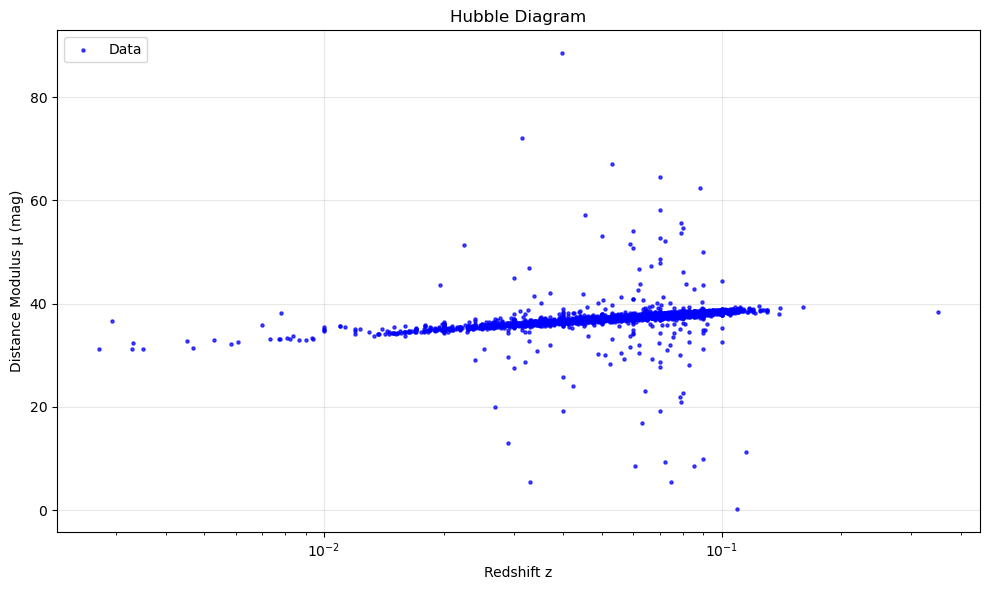

Saved to /Users/david/Code/msc/runs/test5/hubble_residuals.png


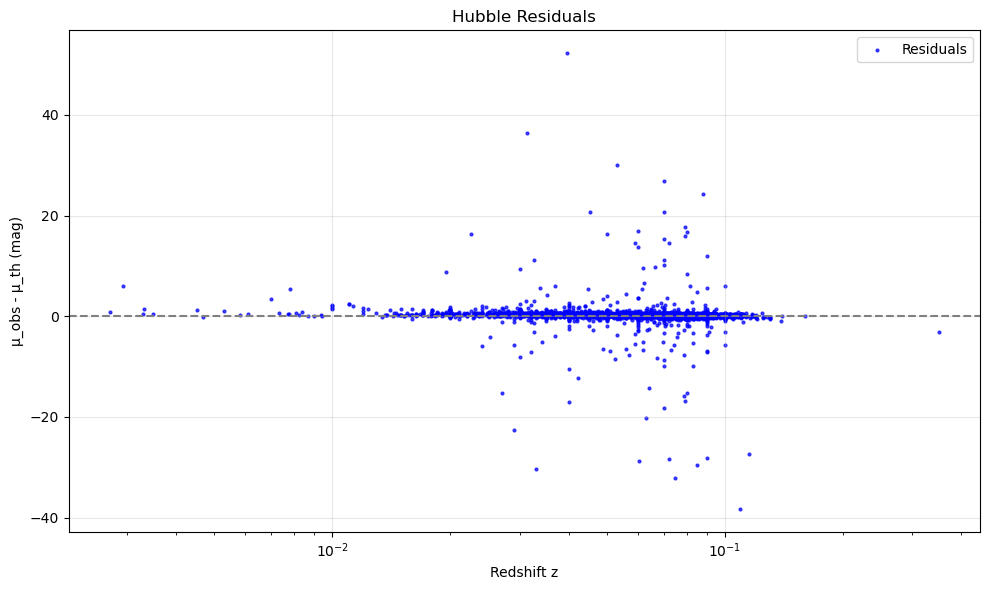

In [ ]:
z_data = dfp["host_redshift"].to_numpy()
mu_obs = dfp["mu_obs"].to_numpy()

# Smooth z grid for theory curves
z_min = max(1e-4, z_data.min() * 0.9)
z_max = z_data.max() * 1.1
z_smooth = np.linspace(z_min, z_max, 300)

# Hubble diagram
plt.figure(figsize=(10, 6))

plt.scatter(dfp["host_redshift"], mu_obs, label="Data", color="blue", s=5, zorder=5, alpha=0.7)
plt.xscale("log")
plt.xlabel("Redshift z")
plt.ylabel("Distance Modulus μ (mag)")
plt.title("Hubble Diagram")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

out_path = run_folder / "hubble_diagram.png"
plt.savefig(out_path, dpi=150)
print(f"Saved to {out_path}")
plt.show()

resid_best = dfp["resid"].to_numpy()

plt.figure(figsize=(10, 6))
plt.axhline(0, color="gray", ls="--")
plt.scatter(dfp["host_redshift"], resid_best, label="Residuals", color="blue", s=4, alpha=0.7)
plt.xscale("log")
plt.xlabel("Redshift z")
plt.ylabel("μ_obs - μ_th (mag)")
plt.title("Hubble Residuals")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

resid_path = run_folder / "hubble_residuals.png"
plt.savefig(resid_path, dpi=150)
print(f"Saved to {resid_path}")
plt.show()